# Style Transfer

## Required libraries

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from PIL import Image
import tensorflow as tf
from IPython.display import display

In [69]:
import sys

In [70]:
# we'll be taking block4_conv4 layers output for content_of_image 
content_layers= ["block4_conv4"]

# for style_of_image we'll be using layers given below in style_layers
style_layers = ["block1_conv2","block2_conv2","block3_conv3","block4_conv3","block5_conv3"]

In [71]:
# For deprocessing the processed image as per required conditions of pre_trained model VGG19
# Firstly, we'll need to add the biases in the processed image
# Here, Obtaining the biases corresponding to zero_input 
zero_input = np.zeros(3).astype("float32")
Biases = preprocess_input(zero_input)

### Deprocess_img

In [72]:
def deprocess(processed_img):
    # add biases which were subtracted during the preprocess
    unprocessed_img = processed_img-Biases
    # unstack the unprocessed image
    unprocessed_img = tf.unstack(unprocessed_img,axis=-1)
    # restack the unprocessed image but with reversed order of BRG-channels
    unprocessed_img = tf.stack([unprocessed_img[2],unprocessed_img[1],unprocessed_img[0]],axis=-1)
    return unprocessed_img

### Define model

In [73]:
def model():
    base_model=VGG19(include_top=False,weights="imagenet")
    base_model.trainable= False
    output = content_layers+style_layers
    output_layers = [base_model.get_layer(layer).output for layer in (output)]
    return Model(base_model.input,output_layers)

### Content_loss

In [74]:
def content_loss(var_img_content,ref_img_content):
    loss = 0.5*tf.reduce_mean(tf.square(var_img_content - ref_img_content))
    return loss

### Style loss

In [75]:
def style_loss(var_img_sty,ref_img_sty):
    img_conte = var_img_sty
    img_conte_2 = ref_img_sty
    img_conte = tf.reshape(img_conte,(img_conte.shape[1]*img_conte.shape[2],img_conte.shape[3]))
    img_conte_2 = tf.reshape(img_conte_2,(img_conte_2.shape[1]*img_conte_2.shape[2],img_conte_2.shape[3]))
    var_img_grm_mat = tf.matmul(np.transpose(img_conte),img_conte)
    ref_img_grm_mat = tf.matmul(np.transpose(img_conte_2),img_conte_2)
    
    channel = var_img_sty.shape[3]
    size = var_img_sty.shape[1]*var_img_sty.shape[2]
    loss=tf.reduce_mean(tf.square(ref_img_grm_mat-var_img_grm_mat)/(4*(channel**2)*(size**2)))
    return loss

### Variational loss

In [76]:
img_h=content_image.shape[1]
img_b = content_image.shape[2]
type(img_b)

int

In [77]:
def variation_loss(var_img):
    x = tf.square(var_img[:,:img_h-1,img_b-1,:] - var_img[:,1:,img_b-1,:])
    y = tf.square(var_img[:,:img_h-1,img_b-1,:] - var_img[:,:img_h-1,1:,:])
    return tf.sum(tf.pow(x+y,variation_factor))

### Total loss

In [78]:
def total_loss(var_img_outputs, ref_content_outputs, ref_style_outputs,alpha=0.86):
    var_img_content = var_img_outputs[0]
    ref_img_content = ref_content_outputs[0]
    content_los=0
    content_los = content_loss(var_img_content,ref_img_content)
    style_los = 0
#     variation_los = variation_loss(var_img_outputs)
    style_loss_1 = style_loss(var_img_outputs[1],ref_style_outputs[1])
    style_loss_2 = style_loss(var_img_outputs[2],ref_style_outputs[2])
    style_loss_3 = style_loss(var_img_outputs[3],ref_style_outputs[3])
    style_loss_4 = style_loss(var_img_outputs[4],ref_style_outputs[4])
    style_los = style_loss_1 + style_loss_2 + style_loss_3 + style_loss_4
    
    loss = (1-alpha)*style_los + alpha*content_los 
    return loss

### Load the Images

In [79]:
japanese_garden = Image.open('japanese_garden.jpg')
portrait = Image.open('picasso_selfportrait.jpg')

### Preprocess the input images

In [80]:
content_image = image.img_to_array(japanese_garden)
content_image = np.expand_dims(content_image, axis=0)
processed_content = preprocess_input(content_image)

style_image = image.img_to_array(portrait)
style_image = np.expand_dims(style_image,axis=0)
processed_style = preprocess_input(style_image)

### Preprocessed content image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


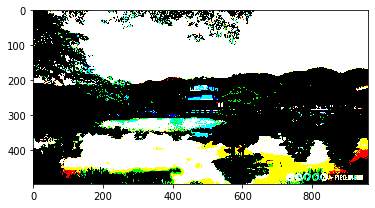

In [81]:
plt.imshow(processed_content[0])

### Preprocessed style image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


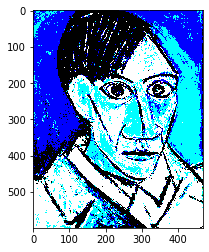

In [82]:
plt.imshow(processed_style[0])

### Outputs of content and style

In [83]:
model = model()
content_outputs = model(processed_content)
style_outputs = model(processed_style)

### Optimization 

In [84]:
optimizer = tf.optimizers.Adam(5,beta_1=.99,epsilon=1e-3)
processed_content_var = tf.Variable(processed_content+tf.random.normal(processed_content.shape))

In [85]:
i=0
best_loss =200000

In [88]:
for i in range(5):   
    with tf.GradientTape() as grad:
        grad.watch(processed_content_var)
        content_var_outputs = model(processed_content_var)
        loss = total_loss(content_var_outputs,content_outputs,style_outputs,alpha=.87)
        grd = grad.gradient(loss,processed_content_var)
        #losses.append(loss)
        optimizer.apply_gradients(zip([grd],[processed_content_var]))
        if loss<best_loss:
            best_image = processed_content_var
            best_loss=loss
        display(loss)

<tf.Tensor: shape=(), dtype=float32, numpy=6282.791>

<tf.Tensor: shape=(), dtype=float32, numpy=6248.4126>

<tf.Tensor: shape=(), dtype=float32, numpy=6202.83>

<tf.Tensor: shape=(), dtype=float32, numpy=6150.9473>

<tf.Tensor: shape=(), dtype=float32, numpy=6095.494>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


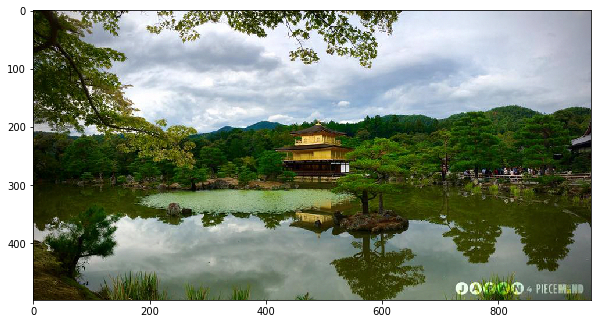

In [89]:
deprocessed_best_image = deprocess(best_image)
plt.figure(figsize=(10,10))
plt.imshow(deprocessed_best_image[0]/255)

In [ ]:
# def gram_matrix(img_content):
#     #change the shape
    
#     img_conte = tf.reshape(img_content,(img_content.shape[1]*img_content.shape[2],img_content.shape[3]))
#     gram = tf.matmul(tf.transpose(img_conte),img_conte)
#     return gram

In [ ]:
# style_outputs[2].type()

In [ ]:
# style_outputs[2]

In [ ]:
# gram_matrix = gram_matrix(style_outputs[2])

In [ ]:
# gram_matrix

In [ ]:
# plt.imshow(gram_matrix)

In [ ]:
# deprocessed_best_image = deprocess(best_image)

In [ ]:
# total_loss(style_outputs,content_outputs,style_outputs)

In [ ]:
# images = []
# losses = []

In [ ]:
# i=0
# best_loss =200000
# for i in range(50):   
#     with tf.GradientTape() as grad:
#         grad.watch(processed_content_var)
#         content_var_outputs = model(processed_content_var)
#         loss = total_loss(content_var_outputs,content_outputs,style_outputs,alpha=.97)
#         grd = grad.gradient(loss,processed_content_var)
#         #losses.append(loss)
#         optimizer.apply_gradients(zip([grd],[processed_content_var]))
#         if loss<best_loss:
#             best_image = processed_content_var
#             best_loss=loss
#         display(loss)
       

In [ ]:
# deprocessed_best_image = deprocess(best_image)

In [ ]:
# plt.figure(figsize=(10,10))
# plt.imshow(deprocessed_best_image[0]/255)

In [ ]:
# i=0
# best_loss =200000
# min_vals = VGG_BIASES
# max_vals = 255+VGG_BIASES
# for i in range(5):   
#     with tf.GradientTape() as tape:
#         tape.watch(processed_content_var)
#         content_var_outputs = model(processed_content_var)
#         loss = total_loss(content_var_outputs,content_outputs,style_outputs,alpha=.97)
#         grad = tape.gradient(loss,processed_content_var)
#         losses.append(loss)
#         optimizer.apply_gradients(zip([grad],[processed_content_var]))
#         clipped = tf.clip_by_value(processed_content_var, min_vals, max_vals)
#         processed_content_var.assign(clipped)
#         if i%5 ==0:
#             images.append(deprocess(processed_content_var))
#         if loss<best_loss:
#             best_image = processed_content_var
#             best_loss=loss
#         display(loss)
       

In [ ]:
# deprocessed_best_image = deprocess(best_image)

In [ ]:
# plt.figure(figsize=(10,10))
# plt.imshow(deprocessed_best_image[0]/255)